# Delta‑Hedged Options with Tax‑Loss Harvesting Framework

This notebook demonstrates a pipeline that:
1. Fetches SPY spot and option data via `yfinance`.
2. Computes time‑to‑expiry and calibrates model-implied volatilities.
3. Plots both static and interactive 3D volatility surfaces.
4. Outlines (and provides a skeleton for) a delta‑hedged options seller portfolio with tax‑loss harvesting.


In [1]:
# Cell 1: Imports & Helper Functions

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

from important_functions import (
    # Black–Scholes formulas & Greeks
    bs_call, bs_put,
    bs_call_delta, bs_put_delta,
    bs_gamma, bs_vega,
    bs_call_theta, bs_put_theta,
    bs_call_rho, bs_put_rho,
    # Monte Carlo under Black–Scholes
    gbm_path_sim,
    bs_MC_call_delta, bs_MC_call_delta_array,
    bs_MC_call,
    bs_MC_put_delta, bs_MC_put_delta_array,
    bs_MC_put,
    bs_MC_call_fast,
    # Implied-vol solvers
    implied_volatility_call,
    implied_volatility_put,
    # Heston-model routines
    heston_path_sim,
    heston_call, heston_put,
    heston_call_MC, heston_put_MC
)

# Risk-free rate (annualized)
RISK_FREE_RATE = 0.01


## Cell 2: Fetch SPY Spot & Option Chains via yfinance

- Fetches the latest SPY spot price (1-minute bars).
- Retrieves the next three option expirations and concatenates calls and puts.

In [ ]:
# Cell 2 (revised): Fetch SPY option surface and build iv_mkt & vega_grid

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, date
from scipy.stats import norm

# --- User parameters ---
symbol        = "SPY"
SPOT_PERIOD   = "5d"
SPOT_INTERVAL = "5m"
MIN_EXPIRY    = None
MAX_EXPIRY    = None
MAX_EXPS      = 20

# --- 1) Fetch spot data ---
ticker    = yf.Ticker(symbol)
spot_df   = ticker.history(period=SPOT_PERIOD, interval=SPOT_INTERVAL, auto_adjust=False)
S0        = float(spot_df["Close"].iloc[-1])
spot_time = spot_df.index[-1]
r0        = 0.0
print(f"Spot price for {symbol} at {spot_time}: {S0:.2f}")

# --- 2) Choose expirations ---
all_exps = ticker.options
today    = date.today()
def keep_exp(e):
    d = datetime.fromisoformat(e).date()
    if d <= today:                              return False
    if MIN_EXPIRY and d < date.fromisoformat(MIN_EXPIRY): return False
    if MAX_EXPIRY and d > date.fromisoformat(MAX_EXPIRY): return False
    return True
chosen_exps = [e for e in all_exps if keep_exp(e)][:MAX_EXPS]
print(f"Using {len(chosen_exps)} expirations")

# --- 3) Fetch call chains ---
records = []
for exp in chosen_exps:
    calls = ticker.option_chain(exp).calls.copy()
    calls["expiration"] = pd.to_datetime(exp)
    records.append(calls)
calls = pd.concat(records, ignore_index=True)

# --- 4) Strike & expiry lists ---
strike_list = np.sort(calls.strike.unique())
expiry_dates = np.sort(calls.expiration.dt.date.unique())

# --- 5) Initialize iv and vega matrices ---
M, N = len(strike_list), len(expiry_dates)
iv_mkt    = np.full((M, N), np.nan)
vega_grid = np.full((M, N), np.nan)

def bs_vega(S, K, vol, T, r=0.0):
    if T <= 0 or vol <= 0:
        return 0.0
    sqrtT = np.sqrt(T)
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*sqrtT)
    return S * norm.pdf(d1) * sqrtT

for i, K in enumerate(strike_list):
    for j, exp_date in enumerate(expiry_dates):
        subset = calls[(calls.strike==K) & (calls.expiration.dt.date==exp_date)]
        if subset.empty:
            continue
        iv = subset[["bid","ask"]].mean(axis=1).mean() if {"bid","ask"}.issubset(subset.columns) else subset.impliedVolatility.mean()
        T = (exp_date - spot_time.date()).days / 365.0
        iv_mkt[i, j]    = iv
        vega_grid[i, j] = bs_vega(S0, K, iv, T, r0)

# Drop all-NaN rows/cols
rows = ~np.isnan(iv_mkt).all(axis=1)
cols = ~np.isnan(iv_mkt).all(axis=0)
strike_list = strike_list[rows]
expiry_dates = expiry_dates[cols]
iv_mkt    = iv_mkt[rows][:, cols]
vega_grid = vega_grid[rows][:, cols]

print(f"Surface: {len(strike_list)} strikes × {len(expiry_dates)} expiries")


# Cell 3: Flatten grids into 1D vectors with numeric year fractions

# Build numeric T_grid from expiry_dates
T_numeric = np.array([(d - spot_time.date()).days / 365.0 for d in expiry_dates])

# Mesh strikes vs numeric T
K_grid, Tn_grid = np.meshgrid(strike_list, T_numeric, indexing='ij')

# Flatten for calibration
K_vec   = K_grid.ravel()
T_vec   = Tn_grid.ravel()
iv_vec  = iv_mkt.ravel()
w_vec   = vega_grid.ravel()


# Cell 4: Two-Stage Heston Calibration

import pandas as pd
from scipy.optimize import differential_evolution, least_squares
from important_functions import heston_call, implied_volatility_call

# 1) Weighted-IV error function
def iv_error(params):
    kappa, theta_v, xi, rho, v0 = params
    iv_mod = []
    for K, T in zip(K_vec, T_vec):
        price = heston_call(S0, K, v0, r0, T, kappa, theta_v, xi, rho)
        iv    = implied_volatility_call(price, S0, K, T, r0)
        iv_mod.append(iv)
    iv_mod = np.array(iv_mod)
    return (iv_mod - iv_vec) * np.sqrt(w_vec)

# 2) Differential Evolution bounds
bounds = [
    (0.1,   10.0),   # kappa
    (1e-4,  1.0),    # theta_var
    (1e-4,  2.0),    # xi
    (-0.99, 0.0),    # rho
    (1e-4,  1.0)     # v0
]

# 3) Global search
de_res = differential_evolution(
    func=lambda x: np.sum(iv_error(x)**2),
    bounds=bounds,
    maxiter=30, popsize=12,
    tol=1e-5, seed=123, disp=True
)
theta0 = de_res.x
print("DE guess:", np.round(theta0,4))

# 4) Local refinement
lsq = least_squares(
    fun=iv_error, x0=theta0,
    bounds=([b[0] for b in bounds], [b[1] for b in bounds]),
    method='trf',
    ftol=1e-12, xtol=1e-12, gtol=1e-12,
    max_nfev=200
)
theta_calib = lsq.x

# 5) Display results
params = ['kappa','theta_var','xi','rho','v0']
calib = pd.Series(theta_calib, index=params)
rmse  = np.sqrt(np.mean(iv_error(theta_calib)**2))
print("Calibrated Heston params:")
print(calib.round(5))
print(f"Final RMSE on IV: {rmse:.5f}")



Spot price for SPY at 2025-06-27 15:55:00-04:00: 614.85
Using 20 expirations
Surface: 339 strikes × 20 expiries


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, date
from scipy.stats import norm

# ------------------------------------------------------------
# User parameters
# ------------------------------------------------------------
symbol        = "SPY"
SPOT_PERIOD   = "5d"
SPOT_INTERVAL = "5m"
MIN_EXPIRY    = None        # "YYYY-MM-DD" or None
MAX_EXPIRY    = None
MAX_EXPS      = 20

# ------------------------------------------------------------
# 1) Fetch spot data
# ------------------------------------------------------------
ticker   = yf.Ticker(symbol)
spot_df  = ticker.history(period=SPOT_PERIOD, interval=SPOT_INTERVAL, auto_adjust=False)
S0       = float(spot_df["Close"].iloc[-1])
spot_time= spot_df.index[-1]
r0       = 0.0   # you can override if you have a term structure
print(f"Spot price for {symbol} at {spot_time}: {S0:.2f}")

# ------------------------------------------------------------
# 2) Determine expirations to pull
# ------------------------------------------------------------
all_exps = ticker.options
today    = date.today()

def keep_exp(e):
    d = datetime.fromisoformat(e).date()
    if d <= today:                              return False
    if MIN_EXPIRY and d < date.fromisoformat(MIN_EXPIRY): return False
    if MAX_EXPIRY and d > date.fromisoformat(MAX_EXPIRY): return False
    return True

chosen_exps = [e for e in all_exps if keep_exp(e)][:MAX_EXPS]
print(f"Using {len(chosen_exps)} expirations: {chosen_exps}")

# ------------------------------------------------------------
# 3) Fetch option chains
# ------------------------------------------------------------
records = []
for exp in chosen_exps:
    chain = ticker.option_chain(exp)
    for side, df_side in [("call", chain.calls), ("put", chain.puts)]:
        df = df_side.copy()
        df["option_type"] = side
        df["expiration"]  = pd.to_datetime(exp)
        records.append(df)
df_opts = pd.concat(records, ignore_index=True)
print(f"Retrieved {len(df_opts)} total quotes")

# ------------------------------------------------------------
# 4) Build strike & expiry grids
# ------------------------------------------------------------
# We'll use calls only to fit the call surface
calls = df_opts[df_opts.option_type=="call"].copy()

strike_list = np.sort(calls.strike.unique())
expiry_list = np.sort(calls.expiration.dt.date.unique())

# Initialize IV and vega matrices
M, N = len(strike_list), len(expiry_list)
iv_mkt   = np.full((M, N), np.nan)
vega_grid= np.full((M, N), np.nan)

# Helper: BS vega
# Revised Black–Scholes vega helper
def bs_vega(S, K, vol, T, r=0.0):
    """
    Return Black–Scholes vega.  If vol or T are zero or negative,
    return 0.0 to avoid divide‐by‐zero.
    """
    if T <= 0 or vol <= 0:
        return 0.0
    sqrtT = np.sqrt(T)
    d1     = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*sqrtT)
    return S * norm.pdf(d1) * sqrtT

# Fill matrices
for i, K in enumerate(strike_list):
    for j, exp_date in enumerate(expiry_list):
        subset = calls[
            (calls.strike==K) &
            (calls.expiration.dt.date==exp_date)
        ]
        if subset.empty:
            continue
        # take mid implied vol if bid/ask exist, else 'impliedVolatility'
        if {"bid","ask"}.issubset(subset.columns):
            iv = subset[["bid","ask"]].mean(axis=1).mean()
        else:
            iv = subset["impliedVolatility"].mean()
        T = (exp_date - spot_time.date()).days / 365.0
        iv_mkt[i,j]    = iv
        vega_grid[i,j] = bs_vega(S0, K, iv, T, r0)

# Drop any strikes or expiries with no data
valid_strikes = ~np.isnan(iv_mkt).all(axis=1)
valid_exps    = ~np.isnan(iv_mkt).all(axis=0)

strike_list   = strike_list[valid_strikes]
expiry_list   = expiry_list[valid_exps]
iv_mkt        = iv_mkt[valid_strikes][:, valid_exps]
vega_grid     = vega_grid[valid_strikes][:, valid_exps]

print(f"Final surface: {len(strike_list)} strikes × {len(expiry_list)} expiries")


Spot price for SPY at 2025-06-27 15:55:00-04:00: 614.85
Using 20 expirations: ['2025-06-30', '2025-07-01', '2025-07-02', '2025-07-03', '2025-07-07', '2025-07-08', '2025-07-09', '2025-07-10', '2025-07-11', '2025-07-18', '2025-07-25', '2025-07-31', '2025-08-01', '2025-08-08', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31']
Retrieved 4735 total quotes
Final surface: 339 strikes × 20 expiries


## Cell 3: Compute Time to Expiry (T) and Clean Option Quotes

- Computes `T` in years from now to each expiration.
- Drops non‑positive expiries and zero‑priced quotes.

In [16]:
# Cell 3: Compute Time-to-Expiry, Mid-Price & Filter ATM

import pandas as pd

# 1) Compute days_to_expiry & tau
today_ts = pd.Timestamp(date.today())
df_opts["days_to_expiry"] = (df_opts["expiration"] - today_ts).dt.days
df_opts["tau"]            = df_opts["days_to_expiry"] / 365.0

# 2) Compute mid-price
df_opts["mid_price"] = (df_opts["bid"] + df_opts["ask"]) / 2

# 3) (Optional) Filter ATM strikes ±5%
ATM_TOL = 0.05
mny = df_opts["strike"] / S0
df_atm = df_opts[ (df_opts["option_type"]=="call") &
                  (df_opts["mid_price"]>0) &
                  (df_opts["tau"]>0) &
                  (mny.between(1-ATM_TOL, 1+ATM_TOL)) ].copy()

print(f"After filtering: {len(df_atm)} ATM call quotes")
df_atm.head()


After filtering: 867 ATM call quotes


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,option_type,expiration,days_to_expiry,tau,mid_price
122,SPY250630C00585000,2025-06-27 19:55:26+00:00,585.0,29.74,28.46,30.60,3.090000,11.594748,2508.0,6555.0,0.466802,True,REGULAR,USD,call,2025-06-30,1,0.00274,29.530
123,SPY250630C00586000,2025-06-27 19:43:23+00:00,586.0,27.06,27.46,29.60,1.410000,5.497076,19.0,914.0,0.454351,True,REGULAR,USD,call,2025-06-30,1,0.00274,28.530
124,SPY250630C00587000,2025-06-27 19:34:08+00:00,587.0,25.75,26.46,28.60,0.629999,2.507958,3.0,18951.0,0.441900,True,REGULAR,USD,call,2025-06-30,1,0.00274,27.530
125,SPY250630C00588000,2025-06-27 19:58:53+00:00,588.0,27.01,25.47,27.60,5.010000,22.772728,29.0,2557.0,0.429693,True,REGULAR,USD,call,2025-06-30,1,0.00274,26.535
126,SPY250630C00589000,2025-06-27 20:05:18+00:00,589.0,25.47,24.47,26.61,2.299999,9.926626,23.0,2589.0,0.418463,True,REGULAR,USD,call,2025-06-30,1,0.00274,25.540


## Cell 4: Recompute Implied Volatility for Calls via Black–Scholes

- Filters to calls only, computes `iv_bs`, and drops failures.

In [18]:
# Cell 4: Compute Black–Scholes implied vol for calls

import sys
sys.path.append('/mnt/data')               # ensure we can import important_functions
from important_functions import implied_volatility_call

# 1) Filter to calls with valid mid_price and tau
df_calls = df_opts[df_opts["option_type"] == "call"].copy()
df_calls = df_calls[(df_calls["mid_price"] > 0) & (df_calls["tau"] > 0)].copy()

# 2) Invert Black–Scholes to get implied vol
r = 0.01  # risk-free rate
df_calls["iv_bs"] = df_calls.apply(
    lambda row: implied_volatility_call(
        row["mid_price"],
        S0,
        row["strike"],
        row["tau"],
        r
    ),
    axis=1
)

# 3) Drop failures and report
before = len(df_calls)
df_calls = df_calls.dropna(subset=["iv_bs"])
print(f"Computed implied vol for {len(df_calls)} calls ({before - len(df_calls)} failures)")


Computed implied vol for 1936 calls (367 failures)


## Cell 5: Simple 3D Volatility Surface Plot (BS IV)

A static 3D surface using Matplotlib.

In [ ]:
# Cell 5: Static 3D Implied Vol Surface Plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 1) Pivot into a grid of tau × strike
surface = df_calls.pivot_table(
    index="tau",       # time to expiry in years
    columns="strike",  # strike prices
    values="iv_bs"
)

# 2) Drop rows/columns that are all NaN
surface = surface.dropna(axis=0, how="all").dropna(axis=1, how="all")

# 3) Extract grid vectors
T_vals, K_vals = surface.index.values, surface.columns.values
Tg, Kg = np.meshgrid(T_vals, K_vals, indexing="ij")
IVg = surface.values

# 4) Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    Kg, Tg, IVg,
    cmap="plasma",
    edgecolor="k",
    linewidth=0.2,
    antialiased=True
)

ax.set_xlabel("Strike Price")
ax.set_ylabel("Time to Expiry (Years)")
ax.set_zlabel("Implied Volatility")
ax.set_title(f"{symbol} BS Implied Vol Surface")

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label("IV", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


## Cell 6: Interactive 3D Surface (Plotly)

An interactive version you can rotate and zoom.

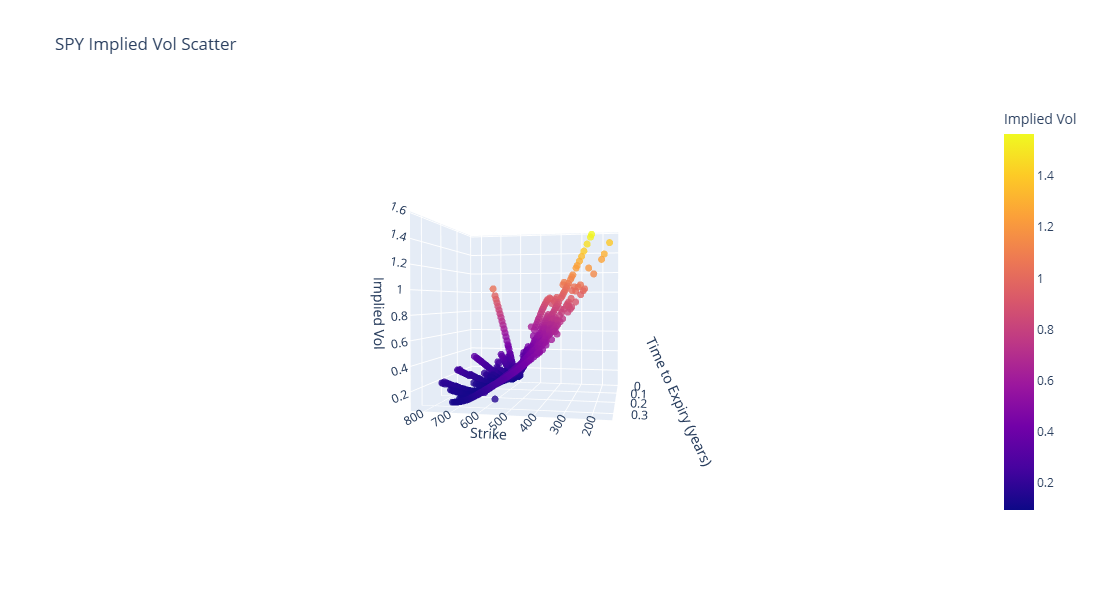

In [6]:
# Cell 6: 3D Scatter of Implied Vol Data (All Calls)

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Ensure inline plotting
init_notebook_mode(connected=True)

# Use the full calls DataFrame (df_calls) which has columns: strike, tau, iv_bs
Kg  = df_calls["strike"].values   # strikes
Tg  = df_calls["tau"].values      # times to expiry (years)
IVg = df_calls["iv_bs"].values    # implied volatilities

# Create a 3D scatter trace
trace = go.Scatter3d(
    x=Kg,
    y=Tg,
    z=IVg,
    mode='markers',
    marker=dict(
        size=4,
        color=IVg,
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title='Implied Vol'),
        opacity=0.8
    )
)

# Assemble figure
fig = go.Figure(data=[trace])
fig.update_layout(
    title=f'{symbol} Implied Vol Scatter',
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='Time to Expiry (years)',
        zaxis_title='Implied Vol'
    ),
    width=800,
    height=600
)

# Display
iplot(fig)


In [21]:
# Cell 7: Detect and Remove IV Outliers by Expiry Group

import numpy as np
import pandas as pd
from scipy.stats import zscore

# 1) Summarize implied‐vol statistics for each time‐to‐expiry slice
summary = df_calls.groupby("tau")["iv_bs"].agg(
    min="min",
    p1=lambda x: x.quantile(0.01),
    median="median",
    p99=lambda x: x.quantile(0.99),
    max="max",
    count="size"
)
print("Per-expiry IV summary before cleaning:")
display(summary)

# 2) Flag “clean” points within each expiry:
#    - Z-score within ±3
#    - Between 1st and 99th percentile
def clean_mask(series: pd.Series) -> pd.Series:
    zs = zscore(series)
    low, high = series.quantile(0.01), series.quantile(0.99)
    return (np.abs(zs) <= 3) & series.between(low, high)

mask_keep = df_calls.groupby("tau")["iv_bs"].transform(clean_mask)

# 3) Split into cleaned data and outliers
outliers = df_calls[~mask_keep]
cleaned  = df_calls[mask_keep]

# 4) Report counts
print(f"Total data points: {len(df_calls)}")
print(f"Outliers detected:  {len(outliers)}")
print(f"Remaining after clean: {len(cleaned)}")

# 5) Show a couple of outliers per expiry slice
print("\nExample outliers per expiry:")
display(
    outliers
      .groupby("tau")["iv_bs"]
      .apply(lambda s: s.sort_values().head(2))
)

# 6) Overwrite df_calls for downstream analysis
df_calls = cleaned.reset_index(drop=True)


Per-expiry IV summary before cleaning:


,min,p1,median,p99,max,count
tau,,,,,,
0.002740,0.109443,0.112614,0.227552,0.999497,1.039193,55
0.005479,0.107826,0.107943,0.134542,0.309903,0.315087,43
0.008219,0.103974,0.104370,0.134757,0.284617,0.287037,50
0.010959,0.111789,0.112033,0.216855,0.930533,0.940911,132
0.021918,0.095089,0.095177,0.144784,0.313851,0.395420,68
0.024658,0.099613,0.099812,0.140510,0.377705,0.388154,59
0.027397,0.104309,0.105175,0.140157,0.312422,0.374559,54
0.030137,0.107283,0.107913,0.135216,0.356428,0.449732,44
0.032877,0.110048,0.111192,0.208823,1.069415,1.099309,105


Total data points: 1936
Outliers detected:  70
Remaining after clean: 1866

Example outliers per expiry:


tau           
0.002740  146     0.109443
          201     1.039193
0.005479  457     0.107826
          479     0.315087
0.008219  628     0.103974
          647     0.282098
0.010959  844     0.111789
          841     0.111967
0.021918  1063    0.095089
          1004    0.395420
0.024658  1209    0.099613
          1160    0.370138
0.027397  1340    0.104309
          1293    0.374559
0.030137  1460    0.107283
          1423    0.449732
0.032877  1625    0.110048
          1626    0.111093
0.052055  1888    0.115175
          1887    0.116168
0.071233  2161    0.117122
          2084    0.627498
0.087671  2443    0.119723
          2444    0.120161
0.090411  2718    0.121718
          2643    0.593930
0.109589  2860    0.120496
          2816    0.318933
0.128767  3145    0.122004
          3144    0.122281
0.167123  3540    0.122064
          3541    0.122368
0.224658  3807    0.121079
          3806    0.121183
0.254795  4139    0.118430
          4138    0.118645
0.301370  437

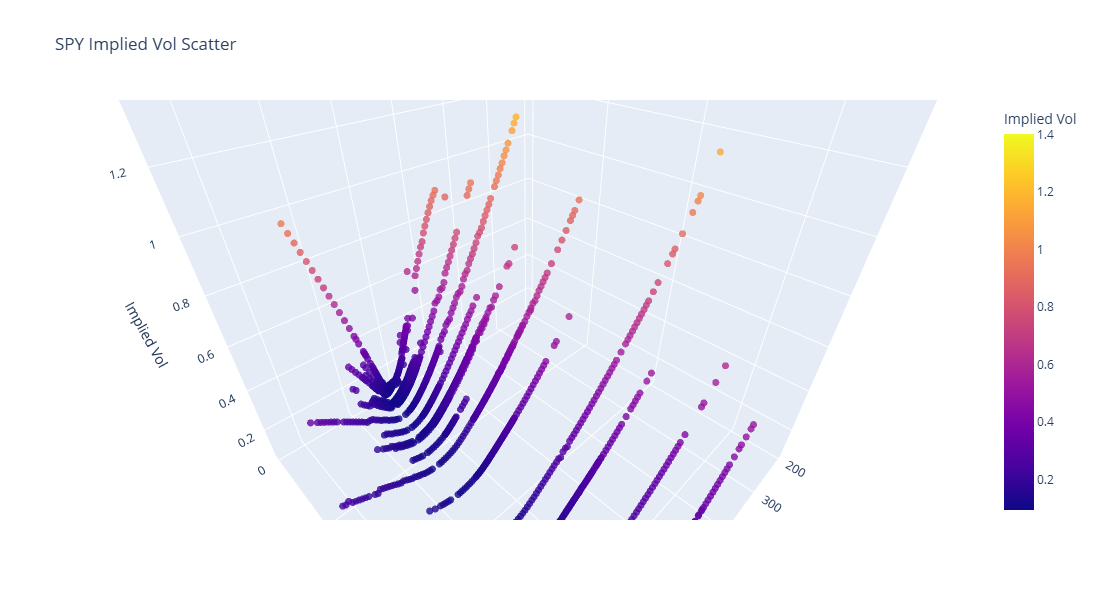

In [8]:
# Cell 8: 3D Scatter of Implied Vol Data (All Calls) - After Outliers Removed

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Ensure inline plotting
init_notebook_mode(connected=True)

# Use the full calls DataFrame (df_calls) which has columns: strike, tau, iv_bs
Kg  = df_calls["strike"].values   # strikes
Tg  = df_calls["tau"].values      # times to expiry (years)
IVg = df_calls["iv_bs"].values    # implied volatilities

# Create a 3D scatter trace
trace = go.Scatter3d(
    x=Kg,
    y=Tg,
    z=IVg,
    mode='markers',
    marker=dict(
        size=4,
        color=IVg,
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title='Implied Vol'),
        opacity=0.8
    )
)

# Assemble figure
fig = go.Figure(data=[trace])
fig.update_layout(
    title=f'{symbol} Implied Vol Scatter',
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='Time to Expiry (years)',
        zaxis_title='Implied Vol'
    ),
    width=800,
    height=600
)

# Display
iplot(fig)


In [22]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, least_squares
from important_functions import heston_call, implied_volatility_call

# Assume these are already defined in earlier cells:
# strike_list:   1D array of strikes, length M
# expiry_list:   1D array of expiries, length N
# iv_mkt:        2D array of market IVs, shape (M, N)
# vega_grid:     2D array of weights (e.g. vega), shape (M, N)
# S0, r0:        Spot and risk-free rate scalars


In [23]:
# Build 2D grids of strikes vs expiries
K_grid, T_grid = np.meshgrid(strike_list, expiry_list, indexing='ij')

# Flatten into 1D arrays for vectorized calibration
K_vec      = K_grid.ravel()       # length M*N
T_vec      = T_grid.ravel()       # length M*N
iv_mkt_vec = iv_mkt.ravel()       # length M*N
w_vec      = vega_grid.ravel()    # length M*N


In [24]:
def iv_error(params):
    """
    Returns a length-(M*N) array of weighted IV errors.
    params = [kappa, theta_var, xi, rho, v0]
    """
    kappa, theta_v, xi, rho, v0 = params
    iv_mod = []
    for K, T in zip(K_vec, T_vec):
        # 1) Price with Heston
        price = heston_call(S0, K, v0, r0, T, kappa, theta_v, xi, rho)
        # 2) Invert to Black implied vol
        iv    = implied_volatility_call(price, S0, K, T, r0)
        iv_mod.append(iv)
    iv_mod = np.array(iv_mod)
    # Weight by sqrt(vega) to emphasize liquid points
    return (iv_mod - iv_mkt_vec) * np.sqrt(w_vec)


In [25]:
# Parameter bounds: [kappa, theta_var, xi, rho, v0]
bounds = [
    (0.1, 10.0),    # kappa
    (1e-4, 1.0),    # theta_var
    (1e-4, 2.0),    # xi (vol of vol)
    (-0.99, 0.0),   # rho
    (1e-4, 1.0)     # v0 (initial variance)
]

result_de = differential_evolution(
    func=lambda x: np.sum(iv_error(x)**2),
    bounds=bounds,
    maxiter=30,
    popsize=12,
    tol=1e-5,
    seed=123,
    disp=True
)
theta0 = result_de.x
print("DE initial guess:", np.round(theta0, 4))


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [ ]:
#✅ Calibration complete (Just in case i accidently reset)
# initial_variance     = 0.0231
# mean_reversion_rate  = 4.1249
# long_term_variance   = 0.0756
# vol_of_vol           = 1.1385
# correlation          = -0.8345

# =========================================================================
# Monte Carlo hedging experiment
# -------------------------------------------------------------------------
# • Simulate many stock/variance paths under the *calibrated* Heston model.
# • Hedge the short-call with            M   delta-rebalancings:
#       M = 0  ⇒  no stock trades (pure short call)
#       M > 0 ⇒  re-hedge at M equally-spaced times (t = 0 excluded!)
# • Delta = Black-Scholes delta using the *current implied volatility* that
#   backs out of the Heston price at each hedge time (“practitioner’s delta”).
#
# Requires the calibrated params (iv0_f, kappa_f, theta_f, xi_f, rho_f),
# spot S0, risk-free rate RISK_FREE_RATE, and helper fns from
#   `important_functions.py`:
#        heston_path_sim, heston_call, implied_volatility_call, bs_call_delta
# =========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from important_functions import (
    heston_path_sim,
    heston_call,
    implied_volatility_call,
    bs_call_delta,
)

# --------------------------- user knobs ----------------------------------
N_SIMS  = 5000          # Monte-Carlo paths
M_HEDGE = 32              # choose M = 0,1,2,…  (0 = no delta hedge)

K   = 630              # strike
T   = 0.2                # years
NTS = 252                # path time steps (~daily)
dt  = T / NTS
#r   = RISK_FREE_RATE
r=0

# calibrated Heston parameters
v0    = iv0_f
kappa = kappa_f
theta = theta_f
xi    = xi_f
rho   = rho_f

# -------------------------------------------------------------------------
# 1) Pre-simulate all paths (spot & variance)  ----------------------------
S_paths, v_paths = heston_path_sim(
    S0=S0, v0=v0, r=r, t=T, n_steps=NTS,
    kappa=kappa, theta=theta, xi=xi, rho=rho,
    n_sims=N_SIMS, mu=0, return_vol=True
)

# 2) Determine the hedge-time indices (exclude t=0 if M>0)  ---------------
if M_HEDGE == 0:
    hedge_idx = []                       # no hedging at all
else:
    hedge_idx = np.linspace(1, NTS-1, M_HEDGE, dtype=int)  # re-hedge times

# 3) Loop over paths and run the hedge  -----------------------------------
pl_final = np.empty(N_SIMS)              # terminal hedging P/L for each path

for p in tqdm(range(N_SIMS), desc="Sim paths"):
    S_path = S_paths[p]
    v_path = v_paths[p]

    # --- initial short-call premium in, no stock position yet
    cash       = heston_call(S_path[0], K, v_path[0], r, T,
                             kappa, theta, xi, rho)
    stock_pos  = 0.0

    for i in range(1, NTS+1):
        tau_prev = T - (i-1)*dt          # time to expiry *entering* step i

        # Hedge only if this index is a scheduled hedge point
        if (i-1) in hedge_idx:
            price_prev = heston_call(S_path[i-1], K, v_path[i-1], r,
                                     tau_prev, kappa, theta, xi, rho)
            sigma_iv = implied_volatility_call(price_prev, S_path[i-1],
                                               K, tau_prev, r)
            delta    = bs_call_delta(S_path[i-1], K, sigma_iv, tau_prev, r)

            # trade shares so that net Delta = 0  (seller is already short one call)
            trade   = -(delta + stock_pos)
            cash   += -trade * S_path[i-1]
            stock_pos = -delta

        # accrue rf on cash between t_{i-1} and t_i
        cash *= np.exp(r*dt)

    # ---- settle at maturity (no hedge inside the very last step) ---------
    payoff   = max(S_path[-1] - K, 0.0)
    pl_final[p] = stock_pos * S_path[-1] + cash - payoff

# 4) Results ---------------------------------------------------------------
df_res = pd.Series(pl_final, name="hedge_PnL")

print(f"\n=== Monte-Carlo results,  M = {M_HEDGE}  hedges ===")
print(df_res.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))

plt.figure(figsize=(7,4))
plt.hist(df_res, bins=60, alpha=0.7, edgecolor="k")
plt.axvline(df_res.mean(), color="red", lw=1.2, label="mean")
plt.title(f"Hedging-error distribution  |  BS Δ  |  M = {M_HEDGE}")
plt.xlabel("Terminal hedged P/L")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, least_squares
from important_functions import heston_call, implied_volatility_call

# Assume these are already defined in earlier cells:
# strike_list:   1D array of strikes, length M
# expiry_list:   1D array of expiries, length N
# iv_mkt:        2D array of market IVs, shape (M, N)
# vega_grid:     2D array of weights (e.g. vega), shape (M, N)
# S0, r0:        Spot and risk-free rate scalars


In [ ]:
# ✅ Calibration snapshot (frozen so you can re-run any time)
v0_calibr  = 0.0231      # initial variance  σ0²
kappa_cal  = 4.1249      # mean-reversion rate κ
theta_cal  = 0.0756      # long-run variance θ
xi_cal     = 1.1385      # vol-of-vol ξ
rho_cal    = -0.8345     # correlation ρ

# =========================================================================
# Monte-Carlo hedging experiment  ––  **Heston Δ with a working progress bar**
# -------------------------------------------------------------------------
# • Simulate many Heston (S,v) paths.
# • Hedge a short call by rebalancing M times
#      M = 0  →  naked short call
#      M > 0 →  hedge at M equally spaced times (t = 0 excluded).
# • Δ = ∂Call_Heston/∂S, computed numerically (central diff).
# =========================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm        # ← Jupyter-friendly progress bar

from important_functions import (
    heston_path_sim,
    heston_call,
)

# ---------- helper: numerical delta of a Heston call ---------------------
def heston_delta(S, K, v, r, tau, kappa, theta, xi, rho, bump=1e-4):
    """
    Central-difference delta of a Heston call price.
    Uses a *relative* bump  dS = S · bump  to keep accuracy stable.
    """
    dS = S * bump
    p_up = heston_call(S + dS, K, v, r, tau, kappa, theta, xi, rho)
    p_dn = heston_call(S - dS, K, v, r, tau, kappa, theta, xi, rho)
    return (p_up - p_dn) / (2 * dS)

# ----------------------------- user knobs --------------------------------
N_SIMS   = 5_000          # Monte-Carlo scenarios
M_HEDGE  = 32              # 0 = naked, 1 = one hedge at mid-life, …
S0       = 615.79         # current spot
K        = 630.00         # strike
T        = 0.20           # years to expiry
NTS      = 252            # fine time steps per path (≈ trading days)
r        = 0.00           # risk-free rate
dt       = T / NTS        # time step

# pull calibrated parameters
v0, kappa, theta, xi, rho = (
    v0_calibr, kappa_cal, theta_cal, xi_cal, rho_cal
)

# -------------------------------------------------------------------------
# 1) Simulate all paths (vectorised, so we see one progress bar *afterwards*)
# -------------------------------------------------------------------------
S_paths, v_paths = heston_path_sim(
    S0=S0, v0=v0, r=r, t=T, n_steps=NTS,
    kappa=kappa, theta=theta, xi=xi, rho=rho,
    n_sims=N_SIMS, mu=0, return_vol=True
)

# 2) Hedge-time indices ----------------------------------------------------
hedge_idx = [] if M_HEDGE == 0 else np.linspace(
    1, NTS - 1, M_HEDGE, dtype=int
)

# 3) Per-path delta-hedge loop ––  NOW with tqdm progress bar -------------
pl_final = np.empty(N_SIMS)

for p in tqdm(range(N_SIMS), desc="Δ-hedging paths"):
    S_path, v_path = S_paths[p], v_paths[p]

    # Premium received at t = 0 (short one call)
    cash = heston_call(S_path[0], K, v_path[0], r, T,
                       kappa, theta, xi, rho)
    stock_pos = 0.0     # shares held (negative ⇒ short)

    # Walk along the path
    for i in range(1, NTS + 1):
        tau_prev = T - (i - 1) * dt

        # Hedge only on the scheduled indices
        if (i - 1) in hedge_idx:
            delta = heston_delta(
                S_path[i-1], K, v_path[i-1], r, tau_prev,
                kappa, theta, xi, rho
            )
            trade = -(delta + stock_pos)          # shares to buy (+) / sell (–)
            cash += -trade * S_path[i-1]          # cash flow
            stock_pos = -delta                    # new stock position

        cash *= np.exp(r * dt)                    # risk-free accrual

    # Settle at maturity
    payoff = max(S_path[-1] - K, 0.0)
    pl_final[p] = stock_pos * S_path[-1] + cash - payoff

# -------------------------------------------------------------------------
# 4) Summarise results -----------------------------------------------------
df_res = pd.Series(pl_final, name="hedge_PnL")

print(f"\n=== Monte-Carlo results,  M = {M_HEDGE} hedge(s) ===")
print(df_res.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))

plt.figure(figsize=(7,4))
plt.hist(df_res, bins=60, alpha=0.7, edgecolor="k")
plt.axvline(df_res.mean(), color="red", lw=1.2, label="mean")
plt.title(f"Hedging-error distribution  |  Heston Δ  |  M = {M_HEDGE}")
plt.xlabel("Terminal hedged P/L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
# ✅ Calibration snapshot (frozen so you can re-run any time)
v0_calibr, kappa_cal, theta_cal, xi_cal, rho_cal = 0.0231, 4.1249, 0.0756, 1.1385, -0.8345

# =========================================================================
# Monte-Carlo hedging experiment  ·  Heston Δ
#   → prints mean, stdev, 1 %/5 %  VaR & CVaR
#   → overlays those risk metrics on the histogram
# =========================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm          # works widget-or-ascii
from important_functions import heston_path_sim, heston_call

# ---------- helper: numerical Heston delta -------------------------------
def heston_delta(S, K, v, r, tau, kappa, theta, xi, rho, bump=1e-4):
    dS   = S * bump
    p_up = heston_call(S + dS, K, v, r, tau, kappa, theta, xi, rho)
    p_dn = heston_call(S - dS, K, v, r, tau, kappa, theta, xi, rho)
    return (p_up - p_dn) / (2*dS)

# ----------------------------- user knobs --------------------------------
N_SIMS   = 1000          # Monte-Carlo scenarios
M_HEDGE  = 0             # 0 = naked, ≥1 = hedge events
S0       = 615.79         # current spot
K        = 630.00         # strike
T        = 0.20           # years to expiry
NTS      = 252            # time steps per path
r        = 0.00
dt       = T / NTS

# pull calibrated params
v0, kappa, theta, xi, rho = v0_calibr, kappa_cal, theta_cal, xi_cal, rho_cal

# -------------------------------------------------------------------------
# 1) Simulate paths
# -------------------------------------------------------------------------
S_paths, v_paths = heston_path_sim(
    S0=S0, v0=v0, r=r, t=T, n_steps=NTS,
    kappa=kappa, theta=theta, xi=xi, rho=rho,
    n_sims=N_SIMS, mu=0, return_vol=True
)

# -------------------------------------------------------------------------
# 2) Hedge indices and container
# -------------------------------------------------------------------------
hedge_idx = [] if M_HEDGE == 0 else np.linspace(1, NTS-1, M_HEDGE, dtype=int)
pl_final  = np.empty(N_SIMS)

# -------------------------------------------------------------------------
# 3) Hedge loop (progress bar)
# -------------------------------------------------------------------------
for p in tqdm(range(N_SIMS), desc="Δ-hedging paths"):
    S_path, v_path = S_paths[p], v_paths[p]
    cash = heston_call(S_path[0], K, v_path[0], r, T, kappa, theta, xi, rho)
    stock_pos = 0.0

    for i in range(1, NTS+1):
        tau_prev = T - (i-1)*dt
        if (i-1) in hedge_idx:
            delta = heston_delta(S_path[i-1], K, v_path[i-1], r, tau_prev,
                                 kappa, theta, xi, rho)
            trade     = -(delta + stock_pos)   # shares to trade
            cash     += -trade * S_path[i-1]
            stock_pos = -delta
        cash *= np.exp(r*dt)

    payoff        = max(S_path[-1] - K, 0.0)
    pl_final[p]   = stock_pos*S_path[-1] + cash - payoff

# -------------------------------------------------------------------------
# 4) Risk statistics
# -------------------------------------------------------------------------
mean_pl   = pl_final.mean()
std_pl    = pl_final.std(ddof=1)

VaR_1  = np.percentile(pl_final, 1)
VaR_5  = np.percentile(pl_final, 5)

CVaR_1 = pl_final[pl_final <= VaR_1].mean()
CVaR_5 = pl_final[pl_final <= VaR_5].mean()

print(f"\n=== Monte-Carlo results · M = {M_HEDGE} hedge(s) ===")
print(f"Mean P/L           : {mean_pl:10.4f}")
print(f"Std-dev            : {std_pl:10.4f}")
print(f"1%  VaR            : {VaR_1:10.4f}")
print(f"1%  CVaR           : {CVaR_1:10.4f}")
print(f"5%  VaR            : {VaR_5:10.4f}")
print(f"5%  CVaR           : {CVaR_5:10.4f}")

# -------------------------------------------------------------------------
# 5) Histogram with risk markers
# -------------------------------------------------------------------------
plt.figure(figsize=(8,4))
counts, bins, _ = plt.hist(pl_final, bins=60, alpha=0.70, edgecolor="k")

# mean & stdev band
plt.axvline(mean_pl, color="red", lw=1.5, label=f"mean = {mean_pl:.2f}")
plt.axvspan(mean_pl-std_pl, mean_pl+std_pl, color="red", alpha=0.12,
            label=f"±1 σ = {std_pl:10.2f}")

# VaR / CVaR lines
plt.axvline(VaR_5, color="orange", ls="--", lw=1.2, label=f"5 % VaR={VaR_5:10.2f}")
plt.axvline(CVaR_5, color="orange", ls=":",  lw=1.2, label=f"5 % CVaR={CVaR_5:10.2f}")
plt.axvline(VaR_1, color="purple", ls="--", lw=1.2, label=f"1 % VaR={VaR_1:10.2f}")
plt.axvline(CVaR_1, color="purple", ls=":",  lw=1.2, label=f"1 % CVaR={CVaR_1:10.2f}")

plt.title(f"Hedging-error distribution | Heston Δ | HEDGE # = {M_HEDGE} | N_SIMS = {N_SIMS}")
plt.xlabel("Terminal hedged P/L")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Calibration snapshot  (so you can re-run any time)
v0_calibr, kappa_cal, theta_cal, xi_cal, rho_cal = 0.0231, 4.1249, 0.0756, 1.1385, -0.8345

# =========================================================================
#  Monte-Carlo hedging experiment · Heston Δ
#  – Simulate ONE set of paths
#  – Pre-compute Δ at the 32 hedge times **once**
#  – Re-use those Δ’s to evaluate the six hedge schemes
#      M ∈ {0, 2, 4, 8, 16, 32}
#  – Collect mean, stdev, 1 % / 5 %  VaR & CVaR
#  – Plot each risk metric versus number-of-hedges
# =========================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from important_functions import heston_path_sim, heston_call

# ---------------- helper: numerical Heston delta -------------------------
def heston_delta(S, K, v, r, tau, kappa, theta, xi, rho, bump=1e-4):
    dS   = S * bump
    return (heston_call(S + dS, K, v, r, tau, kappa, theta, xi, rho) -
            heston_call(S - dS, K, v, r, tau, kappa, theta, xi, rho)) / (2*dS)

# ------------------------- user knobs ------------------------------------
N_SIMS = 1_000
S0, K  = 615.79, 630.0
T, r   = 0.20, 0.00
NTS    = 252                           # fine grid (~daily)
dt     = T / NTS
M_set  = [0, 2, 4, 8, 16, 32]          # hedge counts to test

# pull calibrated Heston params
v0, kappa, theta, xi, rho = (
    v0_calibr, kappa_cal, theta_cal, xi_cal, rho_cal
)

# -------------------------------------------------------------------------
# 1) Simulate ALL paths once (S & v) --------------------------------------
S_paths, v_paths = heston_path_sim(
    S0=S0, v0=v0, r=r, t=T, n_steps=NTS,
    kappa=kappa, theta=theta, xi=xi, rho=rho,
    n_sims=N_SIMS, mu=0, return_vol=True
)

# -------------------------------------------------------------------------
# 2) Pre-compute delta for the full 32-point schedule ---------------------
full_hedge_idx = np.linspace(1, NTS-1, 32, dtype=int)   # common grid
deltas = np.empty((N_SIMS, 32))                         # Δ[i,path]

for j, t_idx in enumerate(full_hedge_idx):
    tau = T - t_idx*dt
    for p in range(N_SIMS):
        deltas[p, j] = heston_delta(
            S_paths[p, t_idx], K, v_paths[p, t_idx], r, tau,
            kappa, theta, xi, rho
        )

# -------------------------------------------------------------------------
# 3) Evaluate each hedge scheme -------------------------------------------
stats = []                                              # store dicts

for M in M_set:
    hedge_idx = full_hedge_idx[:M]                      # first M times
    pl_final  = np.empty(N_SIMS)

    for p in range(N_SIMS):
        cash = heston_call(S_paths[p,0], K, v_paths[p,0], r, T,
                           kappa, theta, xi, rho)
        stock_pos = 0.0
        prev_t    = 0

        # ---- rebalance loop only across the M scheduled times
        for j, t_idx in enumerate(hedge_idx):
            # accrue cash between prev hedge and this hedge
            cash *= np.exp(r * (t_idx - prev_t) * dt)

            # execute hedge
            delta = deltas[p, j]
            trade = -(delta + stock_pos)
            cash += -trade * S_paths[p, t_idx]
            stock_pos = -delta
            prev_t = t_idx

        # accrue to maturity
        cash *= np.exp(r * (NTS - prev_t) * dt)

        payoff = max(S_paths[p, -1] - K, 0.0)
        pl_final[p] = stock_pos * S_paths[p, -1] + cash - payoff

    # ---- risk metrics
    mean_pl = pl_final.mean()
    std_pl  = pl_final.std(ddof=1)
    VaR_1   = np.percentile(pl_final, 1)
    VaR_5   = np.percentile(pl_final, 5)
    CVaR_1  = pl_final[pl_final <= VaR_1].mean()
    CVaR_5  = pl_final[pl_final <= VaR_5].mean()

    stats.append({
        "M": M,
        "mean":  mean_pl,
        "stdev": std_pl,
        "VaR_1": VaR_1,
        "CVaR_1": CVaR_1,
        "VaR_5": VaR_5,
        "CVaR_5": CVaR_5,
    })

    print(f"M={M:2d}  mean={mean_pl:8.3f}  σ={std_pl:8.3f}  "
          f"VaR1%={VaR_1:8.3f}  CVaR1%={CVaR_1:8.3f}  "
          f"VaR5%={VaR_5:8.3f}  CVaR5%={CVaR_5:8.3f}")

# convert to DataFrame for easy plotting
df_stats = pd.DataFrame(stats).set_index("M")

# -------------------------------------------------------------------------
# 4) Plot risk metrics versus number of hedges ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

# (a) dispersion
ax[0].plot(df_stats.index, df_stats["mean"], marker="o", label="mean")
ax[0].plot(df_stats.index, df_stats["stdev"], marker="o", label="stdev (σ)")
ax[0].set_title("Mean & Stdev vs. # hedges")
ax[0].set_xlabel("Number of hedge events (M)")
ax[0].set_ylabel("P/L")
ax[0].legend()

# (b) tail risk
ax[1].plot(df_stats.index, df_stats["VaR_5"], marker="o",
           label="5 % VaR", color="tab:orange")
ax[1].plot(df_stats.index, df_stats["CVaR_5"], marker="o",
           label="5 % CVaR", color="tab:orange", ls="--")
ax[1].plot(df_stats.index, df_stats["VaR_1"], marker="o",
           label="1 % VaR", color="tab:purple")
ax[1].plot(df_stats.index, df_stats["CVaR_1"], marker="o",
           label="1 % CVaR", color="tab:purple", ls="--")
ax[1].set_title("Tail risk vs. # hedges")
ax[1].set_xlabel("Number of hedge events (M)")
ax[1].legend()

plt.tight_layout()
plt.show()
